In [1]:
cd ~/Desktop/ML_project2

/Users/BotezatuCristian/Desktop/ML_project2


# Decision trees (predict the weekday)

In [22]:
# exercise 6.1.2
from sklearn import preprocessing
from sklearn import utils
from matplotlib.pyplot import figure, plot, xlabel, ylabel, legend, show, boxplot
from scipy.io import loadmat
from sklearn import model_selection, tree
import numpy as np

In [110]:
sub_df = df[[ 'season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']]
cols = [ 'season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

# No need for 1-out-of-K coding as we are using the data for classification reasons
# for each in cols:
#     dummies = pd.get_dummies(sub_df[each], prefix=each)
#     sub_df = sub_df.drop(each, axis = 1)
#     sub_df = pd.concat([ dummies, sub_df], axis=1)
    
# sub_df = pd.concat([ df[['hum']], sub_df], axis=1)
# sub_df = pd.concat([ df[['temp']], sub_df], axis=1)
# sub_df = pd.concat([ df[['atemp']], sub_df], axis=1)
# sub_df = pd.concat([ df[['windspeed']], sub_df], axis=1)

X = sub_df.as_matrix()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


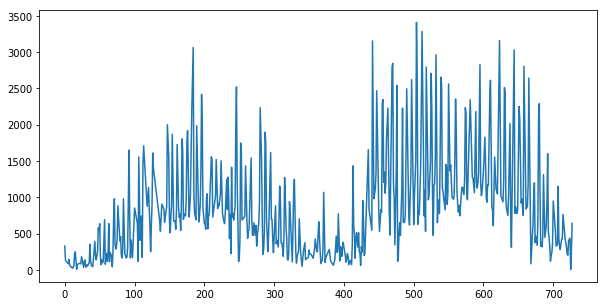

In [111]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import pandas as pd
import numpy as np
df = pd.read_excel('DataSet.xlsx')

df = df[(df.temp<=1) & (df.temp>0) & (df.atemp<=1) & (df.atemp>=0) & (df.hum<=1) & (df.hum>=0) & (df.windspeed <=1) ]
orig_y = df['new']
# df['new'] = np.log(((df['new'] - df['new'].mean()) / df['new'].std()).abs()).abs()
# np.log(((df['new'] - df['new'].mean()) / df['new'].std()).abs()).abs().hist()
# df.head()
plt.plot(df['new'])

# DecisionTreeClassifier for the month

Computing CV fold: 1/10..
Computing CV fold: 2/10..
Computing CV fold: 3/10..
Computing CV fold: 4/10..
Computing CV fold: 5/10..
Computing CV fold: 6/10..
Computing CV fold: 7/10..
Computing CV fold: 8/10..
Computing CV fold: 9/10..
Computing CV fold: 10/10..


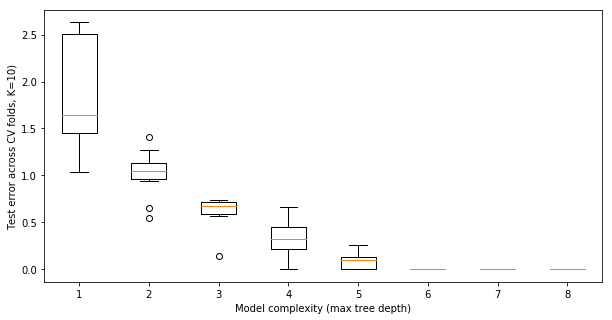

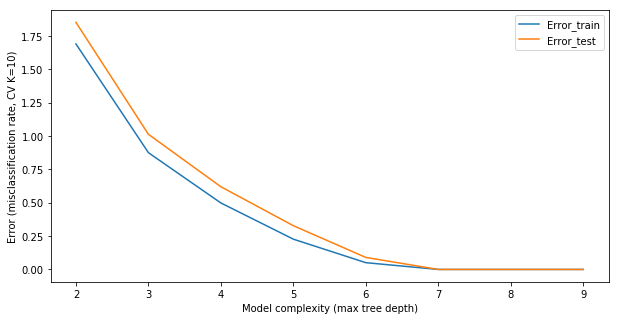

In [112]:
mat_data = X
y = X[:,-5].squeeze()
attributeNames = [name for name in list(sub_df)]
N, M = X.shape
C = 2
# Tree complexity parameter - constraint on maximum depth
tc = np.arange(2, 10, 1)

# K-fold crossvalidation
K = 10
CV = model_selection.KFold(n_splits=K,shuffle=True)

# Initialize variable
Error_train = np.empty((len(tc),K))
Error_test = np.empty((len(tc),K))
k=0
for train_index, test_index in CV.split(X):
    print('Computing CV fold: {0}/{1}..'.format(k+1,K))

    # extract training and test set for current CV fold
    X_train, y_train = X[train_index,:], y[train_index]
    X_test, y_test = X[test_index,:], y[test_index]

    for i, t in enumerate(tc):
        # Fit decision tree classifier, Gini split criterion, different pruning levels
        dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth=t)
#         lab_enc = preprocessing.LabelEncoder()
#         encoded = lab_enc.fit_transform(y_train.ravel())
        dtc = dtc.fit(X_train,y_train.ravel(),sample_weight=None, check_input=True, X_idx_sorted=None)
        
        # Evaluate misclassification rate over train/test data (in this CV fold)
        y_est_test = dtc.predict(X_test)
        y_est_train = dtc.predict(X_train)
        misclass_rate_test = sum(np.abs(y_est_test - y_test)) / float(len(y_est_test))
        misclass_rate_train = sum(np.abs(y_est_train - y_train)) / float(len(y_est_train))
        Error_test[i,k], Error_train[i,k] = misclass_rate_test, misclass_rate_train
    k+=1

    
f = figure()
boxplot(Error_test.T)
xlabel('Model complexity (max tree depth)')
ylabel('Test error across CV folds, K={0})'.format(K))

f = figure()
plot(tc, Error_train.mean(1))
plot(tc, Error_test.mean(1))
xlabel('Model complexity (max tree depth)')
ylabel('Error (misclassification rate, CV K={0})'.format(K))
legend(['Error_train','Error_test'])
    
show()

# Logistic regression vs. Decision tree

CV-fold 1 of 10
CV-fold 2 of 10
CV-fold 3 of 10
CV-fold 4 of 10
CV-fold 5 of 10
CV-fold 6 of 10
CV-fold 7 of 10
CV-fold 8 of 10
CV-fold 9 of 10
CV-fold 10 of 10
Classifiers are significantly different.


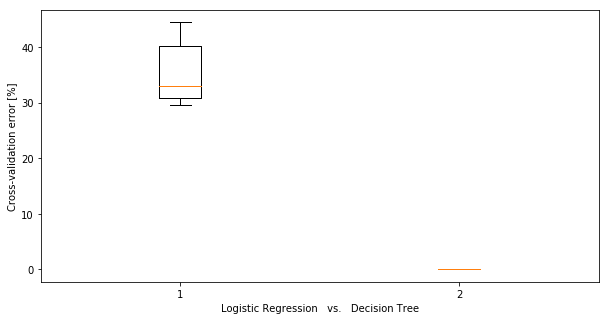

In [119]:
# exercise 6.3.1

from matplotlib.pyplot import figure, boxplot, xlabel, ylabel, show
import numpy as np
from scipy.io import loadmat
import sklearn.linear_model as lm
from sklearn import model_selection, tree
from scipy import stats

# Load Matlab data file and extract variables of interest
mat_data = X

y = X[:,-5].squeeze()
attributeNames = [name for name in list(sub_df)]
N, M = X.shape
C = 2

# Tree complexity parameter - constraint on maximum depth
tc = np.arange(2, 21, 1)

K = 10
CV = model_selection.KFold(n_splits=K,shuffle=True)
#CV = model_selection.StratifiedKFold(n_splits=K)

# Initialize variables
Error_logreg = np.empty((K,1))
Error_dectree = np.empty((K,1))
n_tested=0

k=0
for train_index, test_index in CV.split(X):
    print('CV-fold {0} of {1}'.format(k+1,K))
    
    # extract training and test set for current CV fold
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]

    # Fit and evaluate Logistic Regression classifier
    model = lm.logistic.LogisticRegression(C=N)
    model = model.fit(X_train, y_train)
    y_logreg = model.predict(X_test)
    Error_logreg[k] = 100*(y_logreg!=y_test).sum().astype(float)/len(y_test)
    
    # Fit and evaluate Decision Tree classifier
    model2 = tree.DecisionTreeClassifier()
    model2 = model2.fit(X_train, y_train)
    y_dectree = model2.predict(X_test)
    Error_dectree[k] = 100*(y_dectree!=y_test).sum().astype(float)/len(y_test)

    k+=1

# Test if classifiers are significantly different using methods in section 9.3.3
# by computing credibility interval. Notice this can also be accomplished by computing the p-value using
# [tstatistic, pvalue] = stats.ttest_ind(Error_logreg,Error_dectree)
# and test if the p-value is less than alpha=0.05. 
z = (Error_logreg-Error_dectree)
zb = z.mean()
nu = K-1
sig =  (z-zb).std()  / np.sqrt(K-1)
alpha = 0.05

zL = zb + sig * stats.t.ppf(alpha/2, nu);
zH = zb + sig * stats.t.ppf(1-alpha/2, nu);

if zL <= 0 and zH >= 0 :
    print('Classifiers are not significantly different')        
else:
    print('Classifiers are significantly different.')
    
# Boxplot to compare classifier error distributions
figure()
boxplot(np.concatenate((Error_logreg, Error_dectree),axis=1))
xlabel('Logistic Regression   vs.   Decision Tree')
ylabel('Cross-validation error [%]')

show()

# Analysis of the test error for KN, Logistic regression and Decision trees

In [120]:
from sklearn.neighbors import KNeighborsClassifier
treeModels = [{'purity':p,'minSplit':m} for p in ['gini','entropy'] for m in range(2,100)]
knnModels = [{'k':k} for k in range(2,40)]

y_cont = y
K_fold = 5
CV_out = model_selection.KFold(K_fold, shuffle=True)

Error_train = np.empty((K_fold, 3))
Error_test = np.empty((K_fold, 3))
k = 0
# You can set dist=1 to obtain manhattan distance (cityblock distance).
dist = 2

for train_index, test_index in CV_out.split(X, y_cont):
    
    internal_cross_validation = 5
    CV_in = model_selection.KFold(internal_cross_validation, shuffle=True)
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y_cont[train_index]
    X_test = X[test_index]
    y_test = y_cont[test_index]
#     --------------------------------------------------------------------------------------
    param_err_dec_tree = []
    for o in treeModels:
        err_inner = 0
        for train_index_inner, test_index_inner in CV_in.split(X_train, y_train):
            X_train_inner = X_train[train_index_inner]
            y_train_inner = y_train[train_index_inner]
            X_test_inner = X[test_index]
            y_test_inner = y_cont[test_index]
            dtc = tree.DecisionTreeClassifier(criterion=o['purity'],min_samples_split = o['minSplit'] )
            dtc = dtc.fit(X_train_inner, y_train_inner)
            y_est_inner = dtc.predict(X_test_inner)
            err_inner += sum(np.abs(y_est_inner != y_test_inner))
        param_err_dec_tree.append(err_inner)
    best_param_dec_tree = treeModels[np.argmin(param_err_dec_tree)]
    best_dtc = tree.DecisionTreeClassifier(criterion=best_param_dec_tree['purity'], min_samples_split= best_param_dec_tree['minSplit'])
    best_dtc = best_dtc.fit(X_train, y_train)
    y_est = best_dtc.predict(X_test)
    err_test =  sum(np.abs(y_est != y_test))
    Error_test[k,0] = float(err_test) / y_test.shape[0]

# ------------------------------------------------------------------------------------------------------
    param_err_knn = []
    for o in knnModels:
        err_inner = 0
        for train_index_inner, test_index_inner in CV_in.split(X_train, y_train):
            X_train_inner = X_train[train_index_inner]
            y_train_inner = y_train[train_index_inner]
            X_test_inner = X[test_index]
            y_test_inner = y_cont[test_index]
            # Fit classifier and classify the test points
            knclassifier = KNeighborsClassifier(n_neighbors=o['k'])
            knclassifier.fit(X_train_inner, y_train_inner)
            y_est_inner = knclassifier.predict(X_test_inner)
            err_inner += sum(np.abs(y_est_inner != y_test_inner))
        param_err_knn.append(err_inner)

    best_param_knn = knnModels[np.argmin(param_err_knn)]
    best_knn = KNeighborsClassifier(n_neighbors=best_param_knn['k'])
    best_knn = best_knn.fit(X_train, y_train)
    y_est = best_knn.predict(X_test)
    err_test = sum(np.abs(y_est != y_test))
    Error_test[k, 1] = float(err_test) / y_test.shape[0]
# ------------------------------------------------------------------------------------------------------
    # LOGISTIC REGRESSION
    model = lm.logistic.LogisticRegression()
    model = model.fit(X_train, y_train)
    y_est = model.predict(X_test)
    err_test = sum(np.abs(y_est != y_test))
    Error_test[k, 2] = float(err_test) / y_test.shape[0]
    k+=1

for i in range(3):
    print(Error_test[:,i].mean())

0.0
0.11207951070336393
0.48702004757050626


# Decision tree (classifying the month)

Selected Parameter : {'purity': 'gini', 'minSplit': 2}


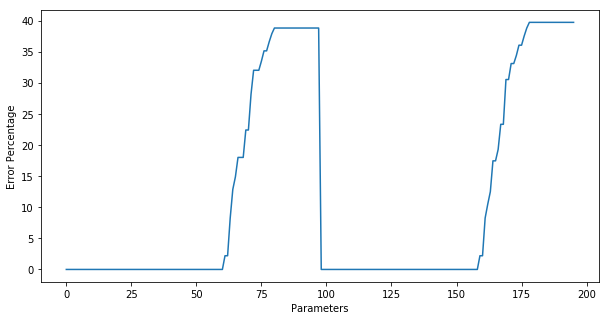

In [121]:
y_cont = X[:,-5].squeeze()
K_fold = 5
CV_out = model_selection.KFold(K_fold, shuffle=True)
treeModels = [{'purity':p,'minSplit':m} for p in ['gini','entropy'] for m in range(2,100)]
param_err_dec_tree = np.zeros(len(treeModels))

for train_index, test_index in CV_out.split(X, y_cont):
    
    internal_cross_validation = 5
    CV_in = model_selection.KFold(internal_cross_validation, shuffle=True)
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y_cont[train_index]
    X_test = X[test_index]
    y_test = y_cont[test_index]
#     --------------------------------------------------------------------------------------

    for index, o in enumerate(treeModels):
        
        dtc = tree.DecisionTreeClassifier(criterion=o['purity'],min_samples_split = o['minSplit'] )
        dtc = dtc.fit(X_train, y_train)
        y_est = dtc.predict(X_test)
        err_inner = 100 *  float(sum(np.abs(y_est != y_test))) / len(y_test)
        param_err_dec_tree[index] += err_inner

        
param_err_dec_tree /= K_fold
best_param_dec_tree = treeModels[np.argmin(param_err_dec_tree)]
plt.plot(param_err_dec_tree)
plt.ylabel('Error Percentage')
plt.xlabel('Parameters')
print('Selected Parameter : ' + str(best_param_dec_tree))

# Decision tree confusion matrix

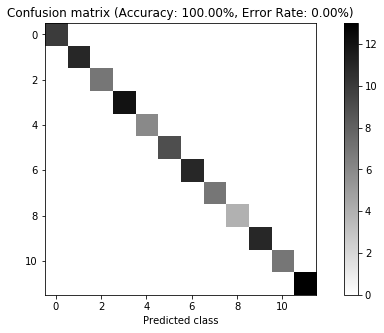

In [122]:
y_cont = X[:,-5].squeeze()
X_train = X[train_index]
y_train = y_cont[train_index]
X_test = X[test_index]
y_test = y_cont[test_index]
# Fit regression tree classifier, Gini split criterion, no pruning
dtc = tree.DecisionTreeClassifier(criterion=best_param_dec_tree['purity'], min_samples_split=best_param_dec_tree['minSplit'])
dtc = dtc.fit(X,y_cont)
y_est_final = dtc.predict(X_test)

# Compute and plot confusion matrix
cm = confusion_matrix(y_est_final, y_test)
accuracy = 100*cm.diagonal().sum()/cm.sum(); error_rate = 100-accuracy
plt.figure(2)
plt.imshow(cm, cmap='binary', interpolation='None')
plt.colorbar()
# plt.xticks(range(C)); yticks(range(C))
plt.xlabel('Predicted class') 
# ylabel('Actual class')
plt.title('Confusion matrix (Accuracy: {0:.2f}%, Error Rate: {1:.2f}%)'.format(accuracy, error_rate))
plt.show()

In [108]:
y_est_final

array([ 1,  1,  1,  1,  2,  2,  2,  3,  3,  4,  5,  6,  6,  6,  7,  7,  7,
        7,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11,  1,  2,  3,  3,  4,
        4,  5,  5,  6,  6,  7,  7,  7,  8,  9, 10, 10, 11, 11, 12, 12, 12,
       12, 12, 12])

# KNeighborsClassifier for month

Selected Parameter : {'k': 3, 'dist': 2}


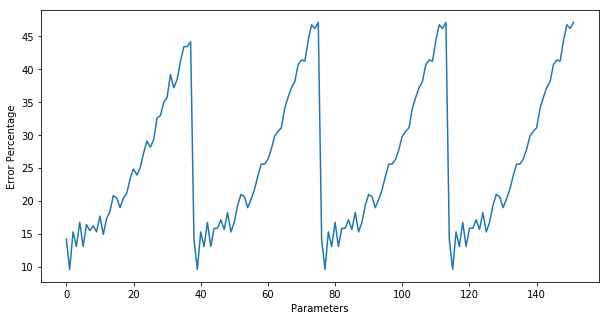

In [123]:
K_fold = 5
CV_out = model_selection.KFold(K_fold, shuffle=True)
knnModels = [{'k':k,'dist':p} for p in range(2,6) for k in range(2,40)]
param_err_k = np.zeros(len(knnModels))

for train_index, test_index in CV_out.split(X, y_cont):
    
    CV_in = model_selection.KFold(internal_cross_validation, shuffle=True)
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y_cont[train_index]
    X_test = X[test_index]
    y_test = y_cont[test_index]
#     --------------------------------------------------------------------------------------

    for index, o in enumerate(knnModels):
        # Fit classifier and classify the test points
        knclassifier = KNeighborsClassifier(n_neighbors=o['k'], p=o['dist'])
        knclassifier.fit(X_train, y_train)
        y_est = knclassifier.predict(X_test)
        err_inner = 100 *  float(sum(np.abs(y_est != y_test))) / len(y_test)
        param_err_k[index] += err_inner

        
param_err_k /= K_fold
best_param_k = knnModels[np.argmin(param_err_k)]
plt.plot(param_err_k)
plt.ylabel('Error Percentage')
plt.xlabel('Parameters')
print('Selected Parameter : ' + str(best_param_k))

# Logistic regression vs. KNN

CV-fold 1 of 10
CV-fold 2 of 10
CV-fold 3 of 10
CV-fold 4 of 10
CV-fold 5 of 10
CV-fold 6 of 10
CV-fold 7 of 10
CV-fold 8 of 10
CV-fold 9 of 10
CV-fold 10 of 10
Classifiers are significantly different.


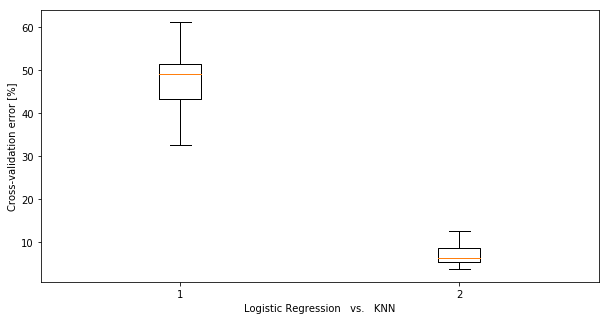

In [124]:
K = 10
CV = model_selection.KFold(n_splits=K,shuffle=True)

# Initialize variables
Error_logreg = np.empty((K,1))
Error_dectree = np.empty((K,1))
n_tested=0

k=0
for train_index, test_index in CV.split(X,y_cont):
    print('CV-fold {0} of {1}'.format(k+1,K))
    
    # extract training and test set for current CV fold
    X_train = X[train_index,:]
    y_train = y_cont[train_index]
    X_test = X[test_index,:]
    y_test = y_cont[test_index]

    # Fit and evaluate Logistic Regression classifier
    model = lm.logistic.LogisticRegression()
    model = model.fit(X_train, y_train)
    y_logreg = model.predict(X_test)
    Error_logreg[k] = 100*(y_logreg!=y_test).sum().astype(float)/len(y_test)
    
    # Fit and evaluate Decision Tree classifier
    model2 = KNeighborsClassifier(n_neighbors=best_param_k['k'], p=best_param_k['dist'])
    model2 = model2.fit(X_train, y_train)
    y_dectree = model2.predict(X_test)
    Error_dectree[k] = 100*(y_dectree!=y_test).sum().astype(float)/len(y_test)

    k+=1

# Test if classifiers are significantly different using methods in section 9.3.3
# by computing credibility interval. Notice this can also be accomplished by computing the p-value using
# [tstatistic, pvalue] = stats.ttest_ind(Error_logreg,Error_dectree)
# and test if the p-value is less than alpha=0.05. 
z = (Error_logreg-Error_dectree)
zb = z.mean()
nu = K-1
sig =  (z-zb).std()  / np.sqrt(K-1)
alpha = 0.05

zL = zb + sig * stats.t.ppf(alpha/2, nu);
zH = zb + sig * stats.t.ppf(1-alpha/2, nu);

if zL <= 0 and zH >= 0 :
    print('Classifiers are not significantly different')        
else:
    print('Classifiers are significantly different.')
    
# Boxplot to compare classifier error distributions
plt.figure()
plt.boxplot(np.concatenate((Error_logreg, Error_dectree),axis=1))
plt.xlabel('Logistic Regression   vs.   KNN')
plt.ylabel('Cross-validation error [%]')

plt.show()

# Logistic regression confusion matrix

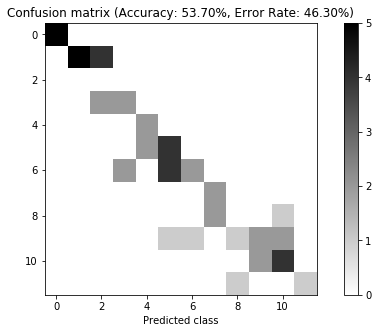

In [125]:
model = lm.logistic.LogisticRegression()
model = model.fit(X,y_cont)
y_est_final = model.predict(X_test)
X_train = X[train_index,:]
y_train = y_cont[train_index]
X_test = X[test_index,:]
y_test = y_cont[test_index]
# Compute and plot confusion matrix
cm = confusion_matrix(y_est_final, y_test)
accuracy = 100*cm.diagonal().sum()/cm.sum(); error_rate = 100-accuracy
plt.figure(2)
plt.imshow(cm, cmap='binary', interpolation='None')
plt.colorbar()
# plt.xticks(range(C)); yticks(range(C))
plt.xlabel('Predicted class') 
# ylabel('Actual class')
plt.title('Confusion matrix (Accuracy: {0:.2f}%, Error Rate: {1:.2f}%)'.format(accuracy, error_rate))
plt.show()


# KN confusion matrix

In [126]:
# Fit classifier and classify the test points
knclassifier = KNeighborsClassifier(n_neighbors=best_param_k['k'], p=best_param_k['dist'])
knclassifier.fit(X, y_cont)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

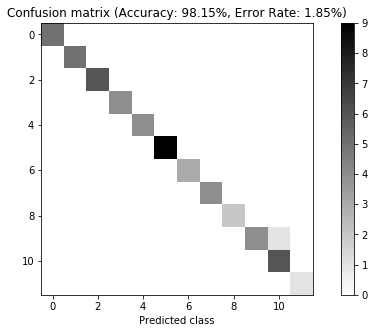

In [127]:
from sklearn.metrics import confusion_matrix
y_est_final = knclassifier.predict(X_test)
X_train = X[train_index,:]
y_train = y_cont[train_index]
X_test = X[test_index,:]
y_test = y_cont[test_index]
# Compute and plot confusion matrix
cm = confusion_matrix(y_est_final, y_test)
accuracy = 100*cm.diagonal().sum()/cm.sum(); error_rate = 100-accuracy
plt.figure(2)
plt.imshow(cm, cmap='binary', interpolation='None')
plt.colorbar()
# plt.xticks(range(C)); yticks(range(C))
plt.xlabel('Predicted class') 
# ylabel('Actual class')
plt.title('Confusion matrix (Accuracy: {0:.2f}%, Error Rate: {1:.2f}%)'.format(accuracy, error_rate))

plt.show()